In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

import numpy as np

from triqs.plot.mpl_interface import plt, oplot, oplotr, oploti
plt.rcParams["figure.figsize"] = (6,5) # set default size for all figures

from scipy.integrate import quad
from scipy.optimize import brentq

# Mean field and RPA response for the one dimensional Hubbard model.

Comparing numerical calculation with rank 4 tensor and analytical results from Fazekas (Ch. 7.4)

Author: Hugo U. R. Strand (2018)

Consider the one dimensional Hubbard model with nearest neighbour hopping

$$
H = -t \sum_{i\sigma} (c^\dagger_{i\sigma} c_{i+1\sigma} + c^\dagger_{i+1\sigma} c_{i\sigma} ) + U \sum_{i} \hat{n}_{i\uparrow} \hat{n}_{i\downarrow}
$$

The non-interacting momentum space dispersion is $\epsilon(k) = -2t \cos k$.

## Mean-field decoupling

$$
\hat{n}_\sigma = \delta\hat{n}_\sigma + n_\sigma
$$

$$
n_\sigma = \langle \hat{n}_\sigma \rangle = \frac{n}{2} \pm m
$$

$$
\hat{n}_{\uparrow} \hat{n}_{\downarrow}
=
\delta\hat{n}_\uparrow
\delta\hat{n}_\downarrow
+
\big(\frac{n}{2} - m\big) \hat{n}_\uparrow
+
\big(\frac{n}{2} + m\big) \hat{n}_\downarrow
- \frac{n^2}{4} + m^2
$$

neglecting fluctuations

$$
H_{MF} =
\sum_{k\sigma} \Big[ \epsilon(k) + \frac{U}{2}n \mp Um \Big] c^\dagger_{k\sigma} c_{k\sigma}
- U \Big( \frac{n^2}{4} - m^2 \Big)
$$


$$
E[n, m] =
\sum_\sigma
\int_{-\pi}^{\pi} \frac{dk}{2\pi}
\tilde{\epsilon}_\sigma(k) f(\tilde{\epsilon}_\sigma(k))
- U \Big( \frac{n^2}{4} - m^2 \Big)
$$

with $\tilde{\epsilon}_\sigma(k) = \epsilon(k) + \frac{U}{2}n \mp Um$

In [2]:
def get_total_energy_mf_ref(t, beta, U, mu, n, m):

    def disp(k, U, n, m, s):
        return -2*t * np.cos(k) - s*U*m + 0.5*U*n
    
    def integrand(k, U, mu, n, m, s):
        e = disp(k, U, n, m, s)
        f = 1./( np.exp(beta * (e - mu)) + 1 )
        return e * f

    E_kin_up, err = quad(integrand, -np.pi, np.pi, args=(U, mu, n, m, +1.))
    E_kin_do, err = quad(integrand, -np.pi, np.pi, args=(U, mu, n, m, -1.))
    E_kin = E_kin_up + E_kin_do
    k_vol = 2*np.pi    
    E_kin *= 1. / k_vol

    E_tot = E_kin - U*(0.25*n**2 - m**2)
    
    return E_tot

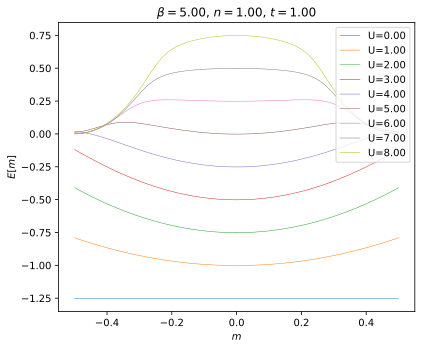

In [3]:
t = 1.0
beta = 5.0
n = 1.0

U_vec = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.])
m_vec = np.linspace(-0.5, 0.5, num=100)

for U in U_vec:
    mu = 0.5*U    
    E_vec = np.array(
        [ get_total_energy_mf_ref(t, beta, U, mu, n, m) 
         for m in m_vec ])
    plt.plot(m_vec, E_vec, '-', lw=0.5, label='U=%2.2f' % U)

plt.title(r'$\beta=%2.2f$, $n=%2.2f$, $t=%2.2f$' % (beta, n, t))
plt.xlabel(r'$m$')
plt.ylabel(r'$E[m]$')
plt.legend(loc='upper right')
plt.tight_layout()

## Analytic susceptibility

Density of states

$$
\rho(\epsilon) = \frac{1}{2t \pi} \frac{1}{ \sqrt{1 - \epsilon^2/(2t)^2 }}
$$

$f(\epsilon) = [e^{\beta \epsilon} + 1]^{-1}$, 

$$\partial_\epsilon f(\epsilon) = -\frac{\beta}{4 \cosh^2(\beta \epsilon/2) }$$

$$
\chi_0(k=0) =
- \int_{-2t}^{2t} d\epsilon \rho(\epsilon) \partial_\epsilon f(\epsilon) 
$$

Instability rule

$$
1 - U \chi_0(k=0) = 0
$$

$$
\chi = \frac{1}{2} \frac{\chi_0}{1 - U \chi_0}
$$

In [4]:
def get_density_of_states(eps, t):
    return 1./np.sqrt(1. - (eps/(2*t))**2) / (2*t * np.pi)

def fermi_distribution(beta, eps):
    return 1./(np.exp(beta*eps) + 1.)

def fermi_distribution_derivative(beta, eps):
    return -beta/4. / np.cosh(0.5*beta*eps)**2

def chi0_q0_integral(t, beta):

    def integrand(eps):
        rho = get_density_of_states(eps, t)
        df = fermi_distribution_derivative(beta, eps)
        return -rho * df

    chi0_q0, err = quad(integrand, -2.*t, 2.*t)

    return chi0_q0        

def find_Uc(t, beta):

    def root_function(U):
        chi0_q0 = chi0_q0_integral(t, beta)
        return 1 - U * chi0_q0

    Uc = brentq(root_function, 0, 100.)
    return Uc

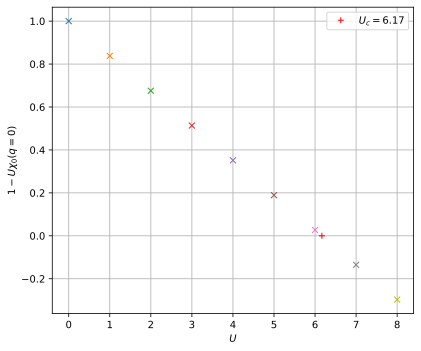

In [5]:
t = 1.0
beta = 5.0
U_vec = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

for U in U_vec:
    chi0_q0 = chi0_q0_integral(t, beta)
    plt.plot(U, 1 - chi0_q0 * U, 'x')

Uc = find_Uc(t, beta)

plt.plot(Uc, 0., '+r', label=r'$U_c=%2.2f$' % Uc)
plt.ylabel(r'$1 - U \chi_0(q=0)$')
plt.xlabel(r'$U$')
plt.legend()
plt.grid()
plt.tight_layout()

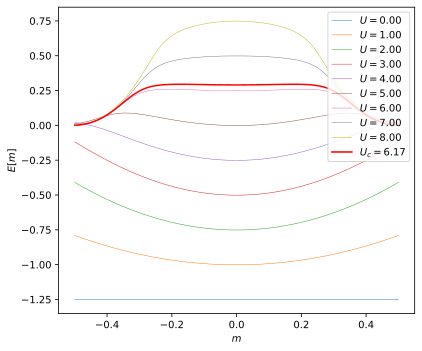

In [6]:
t = 1.0
beta = 5.0
n = 1.0

U_vec = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.])
m_vec = np.linspace(-0.5, 0.5, num=100)

for U in U_vec:
    mu = 0.5*U    
    E_vec = np.array(
        [ get_total_energy_mf_ref(t, beta, U, mu, n, m) 
         for m in m_vec ])
    plt.plot(m_vec, E_vec, '-', lw=0.5, label=r'$U=%2.2f$' % U)

mu = 0.5*Uc
E_vec = np.array(
    [ get_total_energy_mf_ref(t, beta, Uc, mu, n, m) 
    for m in m_vec ])
plt.plot(m_vec, E_vec, 'r-', lw=1.5, label=r'$U_c=%2.2f$' % Uc)
    
plt.xlabel(r'$m$')
plt.ylabel(r'$E[m]$')
plt.legend(loc='upper right')
plt.tight_layout()

## TPRF tensor valued calculation

In [7]:
t = 1.0
#U = 6.1
U = 1.8
mu = 0.5*U

m = 0.0
n = 1.0
    
h_loc = -U*m*np.diag([+1., -1.]) + (0.5*U*n - mu) * np.eye(2)
T = - t * np.eye(2)

from triqs_tprf.tight_binding import TBLattice

t_r = TBLattice(
    units = [(1, 0, 0)],
    hopping = {
        # nearest neighbour hopping -t
        (0,): h_loc,
        (+1,): T,
        (-1,): T,
        },
    orbital_positions = [(0,0,0)] * 2,
    orbital_names = ['up', 'do'],
    )

e_k = t_r.fourier(t_r.get_kmesh(n_k=(256, 1, 1)))

Starting serial run at: 2022-11-28 18:37:53.545682


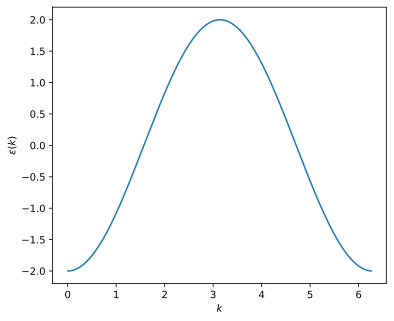

In [8]:
k_vec, e_vec = np.array([ [k.value[0], e_k[k][0,0]] for k in e_k.mesh ]).T
plt.plot(k_vec, e_vec, '-')
plt.xlabel(r'$k$')
plt.ylabel(r'$\epsilon(k)$');

In [9]:
nw = 400
beta = 5.0

from triqs.gf import MeshImFreq, Idx
wmesh = MeshImFreq(beta=beta, S='Fermion', n_max=nw)

from triqs_tprf.lattice import lattice_dyson_g0_wk
g0_wk = lattice_dyson_g0_wk(mu=0., e_k=e_k, mesh=wmesh)

from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk
chi00_wk = imtime_bubble_chi0_wk(g0_wk, nw=1)
print()
print('chi0_q0 =\n', chi00_wk[Idx(0), Idx(0, 0, 0)].real.reshape((4,4)))

print()
import itertools
for idxs in itertools.product(list(range(2)), repeat=4):
    print(idxs, chi00_wk[Idx(0), Idx(0, 0, 0)].real[idxs])
    
chi0_q0_ref = chi0_q0_integral(t, beta)

print()
print('chi0_q0     =', chi00_wk[Idx(0), Idx(0, 0, 0)][0,0,0,0].real)
print('chi0_q0_ref =', chi0_q0_ref)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌┬┐┌─┐┬─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗   │ ├─┘├┬┘├┤ 
 ╩ ╩╚═╩╚═╝╚╚═╝   ┴ ┴  ┴└─└  
Two-Particle Response Function tool-box 

beta  = 5.0
nk    = 256
nw    = 800
norb  = 2

Approx. Memory Utilization: 0.04 GB

--> fourier_wk_to_wr
--> fourier_wr_to_tr
--> chi0_w0r_from_grt_PH (bubble in tau & r)
--> chi_wk_from_chi_wr (r->k)

chi0_q0 =
 [[0.16215903 0.         0.         0.        ]
 [0.         0.         0.16215903 0.        ]
 [0.         0.16215903 0.         0.        ]
 [0.         0.         0.         0.16215903]]

(0, 0, 0, 0) 0.16215902618575762
(0, 0, 0, 1) 0.0
(0, 0, 1, 0) 0.0
(0, 0, 1, 1) 0.0
(0, 1, 0, 0) 0.0
(0, 1, 0, 1) 0.0
(0, 1, 1, 0) 0.16215902618575762
(0, 1, 1, 1) 0.0
(1, 0, 0, 0) 0.0
(1, 0, 0, 1) 0.16215902618575762
(1, 0, 1, 0) 0.0
(1, 0, 1, 1) 0.0
(1, 1, 0, 0) 0.0
(1, 1, 0, 1) 0.0
(1, 1, 1, 0) 0.0
(1, 1, 1, 1) 0.16215902618575762

chi0_q0     = 0.16215902618575762
chi0_q0_ref = 0.1621590261851696


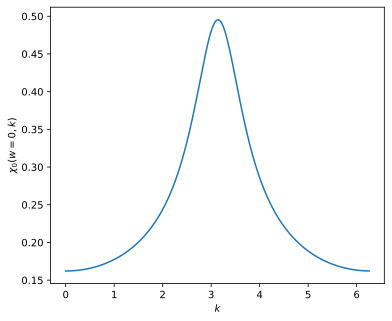

In [10]:
k_vec, chi0_vec = np.array([ [k.value[0], chi00_wk[Idx(0), k][0,0,0,0]] for k in e_k.mesh ]).T
plt.plot(k_vec, chi0_vec, '-')
plt.xlabel(r'$k$')
plt.ylabel(r'$\chi_0(w=0, k)$');

In [11]:
gf_struct = [[0, [0, 1]]]

from triqs.operators import n, c, c_dag, Operator, dagger
H_int = U * n(0, 0) * n(0, 1)
print('H_int =', H_int)

from triqs_tprf.rpa_tensor import get_rpa_tensor
from triqs_tprf.rpa_tensor import fundamental_operators_from_gf_struct

fundamental_operators = fundamental_operators_from_gf_struct(gf_struct)
print(fundamental_operators)
U_abcd = get_rpa_tensor(H_int, fundamental_operators)

print()
print('U_abcd =\n', U_abcd.reshape((4, 4)))

print()
import itertools
for idxs in itertools.product(list(range(2)), repeat=4):
    print(idxs, U_abcd[idxs])

H_int = 1.8*c_dag(0,0)*c_dag(0,1)*c(0,1)*c(0,0)
[1*c(0,0), 1*c(0,1)]

U_abcd =
 [[ 0. +0.j  0. +0.j  0. +0.j -1.8+0.j]
 [ 0. +0.j  0. +0.j  1.8+0.j  0. +0.j]
 [ 0. +0.j  1.8+0.j  0. +0.j  0. +0.j]
 [-1.8+0.j  0. +0.j  0. +0.j  0. +0.j]]

(0, 0, 0, 0) 0j
(0, 0, 0, 1) 0j
(0, 0, 1, 0) 0j
(0, 0, 1, 1) (-1.8+0j)
(0, 1, 0, 0) 0j
(0, 1, 0, 1) 0j
(0, 1, 1, 0) (1.8+0j)
(0, 1, 1, 1) 0j
(1, 0, 0, 0) 0j
(1, 0, 0, 1) (1.8+0j)
(1, 0, 1, 0) 0j
(1, 0, 1, 1) 0j
(1, 1, 0, 0) (-1.8+0j)
(1, 1, 0, 1) 0j
(1, 1, 1, 0) 0j
(1, 1, 1, 1) 0j


In [12]:
from triqs_tprf.lattice import solve_rpa_PH
chi_wk = solve_rpa_PH(chi00_wk, U_abcd)

print('chi_q0 =\n', chi_wk[Idx(0), Idx(0, 0, 0)].real.reshape((4,4)))

print()
for idxs in itertools.product(list(range(2)), repeat=4):
    print(idxs, chi_wk[Idx(0), Idx(0, 0, 0)][idxs].real)

Sz = 0.5 * np.diag([+1., -1.])
chi_SzSz_wk = chi_wk[0,0,0,0].copy()
chi_SzSz_wk.data[:] = np.einsum('wkabcd,ab,cd->wk', chi_wk.data, Sz, Sz)

print()
print('chi_SzSz_q0 =', chi_SzSz_wk[Idx(0), Idx(0, 0, 0)].real)

# Eq. 7.43 Fazekas (additional 0.5 factor)
chi_q0_ref = 0.5 * chi0_q0_ref / (1. - U*chi0_q0_ref)
print('chi_q0_ref =', chi_q0_ref)

C = chi0_q0_ref

print()
print('C/(1-UC) =', C/(1.-U*C))
print('C/(1-U^2C^2) =', C/(1.-U*U*C*C))
print('UC*C/(1-U^2C^2) =', U*C*C/(1.-U*U*C*C))

chi_q0 =
 [[ 0.17726126  0.          0.         -0.05174012]
 [ 0.          0.          0.22900138  0.        ]
 [ 0.          0.22900138  0.          0.        ]
 [-0.05174012  0.          0.          0.17726126]]

(0, 0, 0, 0) 0.17726125649099486
(0, 0, 0, 1) 0.0
(0, 0, 1, 0) 0.0
(0, 0, 1, 1) -0.051740122919478354
(0, 1, 0, 0) 0.0
(0, 1, 0, 1) 0.0
(0, 1, 1, 0) 0.2290013794104732
(0, 1, 1, 1) 0.0
(1, 0, 0, 0) 0.0
(1, 0, 0, 1) 0.2290013794104732
(1, 0, 1, 0) 0.0
(1, 0, 1, 1) 0.0
(1, 1, 0, 0) -0.051740122919478354
(1, 1, 0, 1) 0.0
(1, 1, 1, 0) 0.0
(1, 1, 1, 1) 0.1772612564909948

chi_SzSz_q0 = 0.11450068970523658
chi_q0_ref = 0.11450068970465024

C/(1-UC) = 0.2290013794093005
C/(1-U^2C^2) = 0.17726125649023233
UC*C/(1-U^2C^2) = 0.051740122919068175


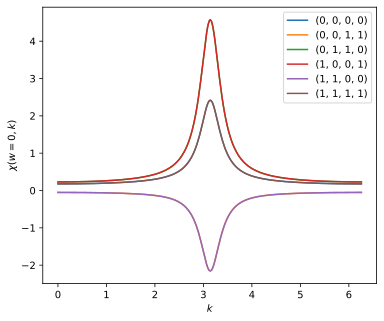

In [13]:
for idxs in itertools.product(list(range(2)), repeat=4):
    k_vec, chi_vec = np.array([ [k.value[0], chi_wk[Idx(0), k][idxs]] for k in e_k.mesh ]).T
    if np.max(np.abs(chi_vec)) == 0.:
        continue
    plt.plot(k_vec, chi_vec, '-', label=idxs.__repr__())
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$\chi(w=0, k)$');

$$
\frac{1}{1 + x} = \sum_k (-x)^k
$$

$$
e^x = \sum_k \frac{(-1)^k}{k!} x^k
$$

$$
f(\epsilon) = \frac{1}{e^{\beta \epsilon} + 1}
= \sum_k (-1)^k e^{k \beta \epsilon}
= \sum_k (-1)^k \sum_l \frac{(-1)^l}{l!} (k \beta \epsilon)^l
$$

$$
f( e \mathbf{1} + \eta \sigma_x )
$$

special case $[\mathbf{1}, \sigma_x] = 0$, anything commutes with $\mathbf{1}$!

Q: $[A, B] = 0$?

Want
$$
\lim_{\eta \rightarrow 0}
\frac{ f( A + \eta B ) - f(A) } { \eta } ?=? B f'(A)
$$
in the general case $[A , B] \ne 0$

No what we want is slightly less general $A = A^\dagger$ and $B = B^\dagger$ and $B$ has only two non-zero terms that are unity.



In [14]:
def chi0_q0_integral_kspace(t, beta):
    
    def disp(k, t):
        return -2.* t * np.cos(k)
    
    def integrand(k, t, beta):
        ek = disp(k, t)
        val = - fermi_distribution_derivative(beta, ek)
        return val
    
    chi0_q0, err = quad(integrand, -np.pi, np.pi, args=(t, beta))
    
    chi0_q0 *= 1./(2.*np.pi)
    
    return chi0_q0


def fdm(E, beta):
    from scipy.linalg import expm
    I = np.eye(E.shape[0])
    return np.mat(np.linalg.inv(expm(beta * E) + I))

def dfdm(E, beta):
    from scipy.linalg import coshm
    B = np.mat(coshm(0.5*beta*E))
    return -0.25 * beta * np.mat(np.linalg.inv(B*B))

beta = 5.0
t = 1.0

chi0_q0_ref = chi0_q0_integral(t, beta)
chi0_q0_ref2 = chi0_q0_integral_kspace(t, beta)

print(chi0_q0_ref)
print(chi0_q0_ref2)

0.1621590261851696
0.16215902618584552


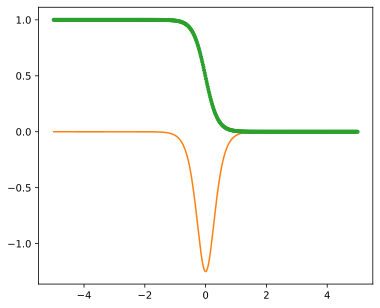

In [15]:
e_vec = np.linspace(-5, 5, num=500)

f = np.array([fdm(np.array([[e]]), beta) for e in e_vec ])
df = np.array([dfdm(np.array([[e]]), beta) for e in e_vec ])

plt.plot(e_vec, np.squeeze(f))
plt.plot(e_vec, np.squeeze(df))

de = e_vec[1] - e_vec[0]
df_ref = 1 + np.cumsum(np.squeeze(df)) * de
plt.plot(e_vec, df_ref, '.')


In [16]:
E = 0.1 * np.mat(np.eye(2))
sx = np.mat(np.rot90(np.eye(2)))
print(E)
print(sx)

fdm(E, beta)

eta = 1e-9

df = (fdm(E + eta*sx, beta) - fdm(E, beta)) / eta
df_ref = dfdm(E, beta) * sx

print(type(df_ref))

print(df)
print(df_ref)

[[0.1 0. ]
 [0.  0.1]]
[[0. 1.]
 [1. 0.]]
<class 'numpy.matrix'>
[[ 0.         -1.17501856]
 [-1.17501856  0.        ]]
[[ 0.         -1.17501856]
 [-1.17501856  0.        ]]


In [17]:
A = 0.1 * np.mat(np.random.random((4, 4)))

#B = np.mat(np.rot90(np.eye(4)))
B = np.zeros((4, 4))
B[0,0] = 1
print('A=\n', A)
print('B=\n', B)

print(fdm(A, beta))

eta = 1e-9

df = (fdm(A + eta*B, beta) - fdm(A - eta*B, beta)) / (2.*eta)
df_ref = dfdm(A, beta) * B - B * dfdm(A, beta)
 
#print type(df_ref)

print(df)
print(df_ref)

A=
 [[0.07849877 0.09114177 0.08684697 0.07759532]
 [0.03165219 0.06067662 0.07194691 0.07645705]
 [0.05044861 0.08479696 0.07165017 0.01418816]
 [0.05117554 0.07045671 0.04080937 0.08892701]]
B=
 [[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[ 0.411733   -0.09926083 -0.09548816 -0.08467789]
 [-0.03274846  0.43430499 -0.08088074 -0.08694818]
 [-0.05666184 -0.09639342  0.41904937 -0.00994773]
 [-0.05653489 -0.07706607 -0.04132973  0.39834955]]
[[-1.16102719  0.06879425  0.06239114  0.05735723]
 [ 0.03025787  0.00358702  0.00356259  0.00309752]
 [ 0.03157315  0.00756179  0.00738609  0.00648693]
 [ 0.03557602  0.00727935  0.00713022  0.00625155]]
[[ 0.         -0.1550631  -0.13843143 -0.12831125]
 [ 0.07270238  0.          0.          0.        ]
 [ 0.06653656  0.          0.          0.        ]
 [ 0.07801288  0.          0.          0.        ]]


In [18]:
def chi0_q0_integral_kspace_matrix(idxs, t, beta):
    
    def disp(k, t):
        return -2.* t * np.cos(k) * np.array([[1.1, 0.1], [0.1, 0.9]])
    
    def integrand(k, t, beta, idxs):

        a, b, c, d = idxs
        
        ek = disp(k, t)
        
        # -- Field
        F = np.zeros((2,2))

        #F[a,b] = 1
        F[b,a] = 1
        
        eta = 1e-9
        df = (fdm(ek + eta*F, beta) - fdm(ek - eta*F, beta)) / (2.*eta)
        
        return -df[c, d]
    
    chi0_q0, err = quad(integrand, -np.pi, np.pi, args=(t, beta, idxs))
    
    chi0_q0 *= 1./(2.*np.pi)
    
    return chi0_q0

beta, t = 5.0, 1.0

idxs_vec = [
    (0, 0, 0, 0),
    (0, 1, 0, 1),
    (1, 0, 1, 0),
    (0 ,1, 1, 0),
    (1 ,0, 0, 1),
    (1, 1, 1, 1),
    ]

chi0_q0 = np.zeros((2, 2, 2, 2))

#for idxs in idxs_vec:
for idxs in itertools.product(list(range(2)), repeat=4):
    chi0_q0[idxs] = chi0_q0_integral_kspace_matrix(idxs, t, beta)
    print(idxs, chi0_q0[idxs])

print()
print(chi0_q0.reshape((4, 4)))

(0, 0, 0, 0) 0.14793391060298283
(0, 0, 0, 1) -0.008038349928730698
(0, 0, 1, 0) -0.008038349962780965
(0, 0, 1, 1) 0.0006233707892106677
(0, 1, 0, 0) -0.008038350008033742
(0, 1, 0, 1) 0.0006233706641155508
(0, 1, 1, 0) 0.16401061049898624
(0, 1, 1, 1) -0.009285091732912957
(1, 0, 0, 0) -0.008038349880358679
(1, 0, 0, 1) 0.16401061049424814
(1, 0, 1, 0) 0.0006233706995989131
(1, 0, 1, 1) -0.009285091732013022
(1, 1, 0, 0) 0.0006233731618443998
(1, 1, 0, 1) -0.009285091109012182
(1, 1, 1, 0) -0.009285091169182682
(1, 1, 1, 1) 0.1825807922880451

[[ 0.14793391 -0.00803835 -0.00803835  0.00062337]
 [-0.00803835  0.00062337  0.16401061 -0.00928509]
 [-0.00803835  0.16401061  0.00062337 -0.00928509]
 [ 0.00062337 -0.00928509 -0.00928509  0.18258079]]
